# Week 1 - Counting Words & Phrases

This week, we take text corpora that we have developed, spidered, scraped, and encoded, and we find and count words, simple and parsed phrases and explore the statistical properties of those counts (e.g., word frequency distributions). Initially, we model how to search corpora for keywords or phrases. Next, we examine the distributions of terms and phrases across a corpus, and the correlation between different words and phrase counts. In order to do this effectively, we coarsely disambiguate words based of part-of-speech (POS) tagging, and normalize them through stemming and lemmatization. Next we distinguish *important* words and phrase within the corpus, and image them with Wordls! Then we calculate word frequenceis, conditional frequences (the frequency of word *shock* conditional on the presence of word *awe*), and statistically significant collocations of lengths 2 through $n$. Finally, we calculate and visualize Differences (Divergences and Distances) between the word frequency distributions from two corpora. 

Then we shift to focus not simply on the *ideas* in a corpus, but also extracting precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases.

We will be introducing spaCy as a package for Computational Linguistics, and also walk you through how to use the Davies Corpora. 

While we wish to avoid using NLTK for heavy corpus analysis, some of its smaller functions can still be useful.

Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:


In [274]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud_2020 #pip install git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

In [275]:
nlp = spacy.load("en")

In [276]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

# Counting words

If we want to do some analysis we can start by simply counting the number of times each word occurs within the corpus.

In [277]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

In [278]:
import nltk

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that input and interrogate a corpus relating to your anticipated final project. This could include one of the Davies corpora or some other you have constructed. Turn your text into an nltk `Text` object, and explore all of the features examined above, and others that relate to better understanding your corpus in relation to your research question. </span>

In [279]:
# Corpus from https://www.kaggle.com/ryanxjhan/cbc-news-coronavirus-articles-march-26
covid_news = pandas.read_csv("news.csv")

# Extract date
covid_news['year'] = covid_news['publish_date'].apply(lambda x: int(x[0:4]))
covid_news['mon'] = covid_news['publish_date'].apply(lambda x: int(x[5:7]))
covid_news['day'] = covid_news['publish_date'].apply(lambda x: int(x[8:10]))

# Small number of news are about SARS and MERS
covid_news = covid_news[covid_news['year'] > 2018]

# Sort news from the oldest to the most recent
covid_news.sort_values(['year', 'mon', 'day'], inplace = True)

# Select important columns
covid_news = covid_news[['year', 'mon', 'day', 'authors', 'title', 'description','text']]

In [407]:
covid_news

,year,mon,day,authors,title,description,text,tokenized_title,tokenized_desc,tokenized_text,normalized_tokens,normalized_tokens_count,normalized_tokens_POS,md
891,2019,12,22,['Cbc News'],Sunday Scrum: Repatriating Canadians from Chin...,CBC News Network's Sunday Scrum panel is your ...,CBC News Network's Sunday Scrum panel is your ...,"[Sunday, Scrum, Repatriating, Canadians, from,...","[CBC, News, Network, 's, Sunday, Scrum, panel,...","[CBC, News, Network, 's, Sunday, Scrum, panel,...","[cbc, news, network, sunday, scrum, panel, des...",174,"[(cbc, NNP), (news, NNP), (network, NN), ('s, ...",2019-12-22
3533,2020,1,8,['The Associated Press'],South Korea reports 1st possible case of viral...,South Korea has put a 36-year-old Chinese woma...,South Korea has put a 36-year-old Chinese woma...,"[South, Korea, reports, 1st, possible, case, o...","[South, Korea, has, put, a, 36-year, old, Chin...","[South, Korea, has, put, a, 36-year, old, Chin...","[south, korea, 36-year, old, chinese, woman, i...",305,"[(south, NNP), (korea, NNP), (has, VBZ), (put,...",2020-1-8
3378,2020,1,9,['Thomson Reuters'],Previously unknown virus may be causing pneumo...,A preliminary investigation has now identified...,A cluster of more than 50 pneumonia cases in C...,"[Previously, unknown, virus, may, be, causing,...","[A, preliminary, investigation, has, now, iden...","[A, cluster, of, more, than, 50, pneumonia, ca...","[cluster, pneumonia, case, china, central, wuh...",311,"[(a, DT), (cluster, NN), (of, IN), (more, JJR)...",2020-1-9
3400,2020,1,9,['Thomson Reuters'],Previously unknown virus may be causing pneumo...,A preliminary investigation has now identified...,A cluster of more than 50 pneumonia cases in C...,"[Previously, unknown, virus, may, be, causing,...","[A, preliminary, investigation, has, now, iden...","[A, cluster, of, more, than, 50, pneumonia, ca...","[cluster, pneumonia, case, china, central, wuh...",311,"[(a, DT), (cluster, NN), (of, IN), (more, JJR)...",2020-1-9
879,2020,1,11,['The Associated Press'],China reports 1st death from 'new type of coro...,Health authorities in the central Chinese city...,Health authorities in a central Chinese city o...,"[China, reports, 1st, death, from, new, type, ...","[Health, authorities, in, the, central, Chines...","[Health, authorities, in, a, central, Chinese,...","[health, authority, central, chinese, city, sa...",353,"[(health, NN), (authorities, NNS), (in, IN), (...",2020-1-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,2020,3,27,[],"City of Regina laying off 360 casual staff, no...",The City of Regina says staff will be reduced ...,The City of Regina has issued layoff notices t...,"[City, of, Regina, laying, off, 360, casual, s...","[The, City, of, Regina, says, staff, will, be,...","[The, City, of, Regina, has, issued, layoff, n...","[city, regina, issue, layoff, notice, casual, ...",183,"[(the, DT), (city, NN), (of, IN), (regina, NNP...",2020-3-27
281,2020,3,27,['Cbc News'],Vancouver police report recent spike in commer...,Vancouver police say there’s been an increase ...,Vancouver police say there's been an increase ...,"[Vancouver, police, report, recent, spike, in,...","[Vancouver, police, say, there, ’s, been, an, ...","[Vancouver, police, say, there, 's, been, an, ...","[vancouver, police, increase, theft, commercia...",196,"[(vancouver, NNP), (police, NNS), (say, VBP), ...",2020-3-27
308,2020,3,27,['Cbc News'],10 public health workers in the Eastern Townsh...,Public health authorities in the Eastern Towns...,Ten public health employees in the Eastern Tow...,"[10, public, health, workers, in, the, Eastern...","[Public, health, authorities, in, the, Eastern...","[Ten, public, health, employees, in, the, East...","[public, health, employee, eastern, township, ...",173,"[(ten, CD), (public, JJ), (health, NN), (emplo...",2020-3-27
456,2020,3,27,[],WATCH: Portraits at a safe social distance rai...,Collecting donations for Winnipeg Harvest inst...,"Photographers around the wo

This corpus consists of more than 3,500 CBC news articles about COVID-19/News Coronavirus.

In [280]:
# tokenize news title
covid_news['tokenized_title'] = covid_news['title'].apply(word_tokenize)

In [281]:
# tokenize news description
covid_news['tokenized_desc'] = covid_news['description'].apply(word_tokenize)

In [283]:
# tokenize news text
covid_news['tokenized_text'] = covid_news['text'].apply(word_tokenize)

In [284]:
# drop any possible NA
covid_news.dropna(inplace=True)

In [285]:
# combine all text tokens from all news
covid_token = [element for list_ in covid_news['tokenized_text'].values for element in list_ \
              if not element.startswith(("@","&","\'","<","=",">"))]

In [286]:
# most frequent tokens
countedWords = wordCounter(covid_token)
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:20]

,word,count
15,the,133762
30,to,85387
14,of,61342
12,and,59275
37,in,53618
54,a,47357
157,said,30240
9,for,27335
6,is,26192
181,that,25940


Before normalization, most frequent tokens are not very significant or meaningful.

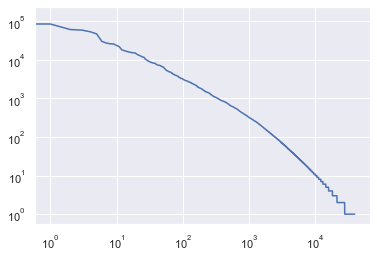

In [287]:
# Zipf's law
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

The frequencies follow the Zipf's law well!

In [288]:
# counts of interesting tokens
countedWords.loc[countedWords['word'].isin(['covid-19', 'coronavirus', 'death', 'china', 'pandemic'])]

,word,count
1660,covid-19,14320
34,coronavirus,9158
38,china,4051
3072,pandemic,3379
53,death,1131


In [289]:
# turn all tokens into NLTK Text and ConcordanceIndex objects
covidText = nltk.Text(covid_token)
covidIndex = nltk.text.ConcordanceIndex(covidText) 

In [290]:
covidIndex.print_concordance('COVID-19')

Displaying 25 of 14283 matches:
 measures against the spread of the COVID-19 in Vatican City Italy Elisabetta A.
tory Syndrome SARS CoV Canada first COVID-19 death is not cause for panic but sh
tial symptoms of the illness called COVID-19 are mainly fever and cough with a f
ld Canadians do Major problems with COVID-19 outbreaks have occurred on cruise s
avoid all cruise ship travel due to COVID-19 Tam said The risk to the general po
orld 6:57 6 What we do n't know yet COVID-19 has created alarm because there are
d in December CBC ExplainsDo I have COVID-19 the flu or a cold?'Just incredible 
k remains low CBC ExplainsDo I have COVID-19 the flu or a cold About five or six
virus spreads CBC ExplainsDo I have COVID-19 the flu or a cold He adds if there 
orted in ChinaCBC ExplainsDo I have COVID-19 the flu or a cold One of the patien
 like illness CBC ExplainsDo I have COVID-19 the flu or a cold?Coronavirus death
om on Dec. 23 CBC ExplainsDo I have COVID-19 the flu or a cold?Follow the spr

In [291]:
covidIndex.print_concordance('death')

Displaying 25 of 1099 matches:
ership race We also discuss what the death of a sex worker says about the curre
e Derek Sloan 10:31 WATCH Sex worker death prompts joint investigation The deat
eath prompts joint investigation The death of 22-year old Marylène Levesque is 
 outbreak for weeks before a growing death toll and rumors forced the governmen
 outbreak for weeks before a growing death toll and rumors forced the governmen
 Saturday reported the country first death from a new type of coronavirus as th
us related to SARS?China reports 1st death from new type of coronavirus Among 4
cases of the infection including one death have been identified in Wuhan City C
 in China WHO says China reports 1st death from new type of coronavirus The app
cases of the infection including one death have been identified in Wuhan City C
 in China WHO says China reports 1st death from new type of coronavirus The app
ld man had died in China first known death from the virus The Wuhan Municipal H
Health Co

In [292]:
# random 20 collocations occur in the news
covidText.collocation_list()

['per cent',
 'public health',
 'social distancing',
 'Nova Scotia',
 'CBC News',
 'self isolate',
 'health care',
 'tested positive',
 'Public Health',
 'novel coronavirus',
 'confirmed cases',
 'self isolation',
 'cruise ship',
 'federal government',
 'health officials',
 'medical officer',
 'Prime Minister',
 'New Brunswick',
 'hand sanitizer',
 'non essential']

In [293]:
covidText.common_contexts(['COVID-19', 'Coronavirus'])

the_in first_death with_outbreaks of_cases of_are with_the with_in
for_in with_has have_but of_patients of_the to_but of_in of_aboard
as_but the_response for_on with_on of_infection


In [294]:
# 20 tokens most similar to 'China'
covidText.similar('China')

canada the covid-19 it wuhan that ontario italy ottawa toronto people
coronavirus alberta b.c. iran this manitoba quebec japan europe


In [295]:
covidText.similar('COVID')

covid-19 coronavirus sars a wuhan health virus global them us the
current outbreak march people it emergency ebola h1n1 canadian


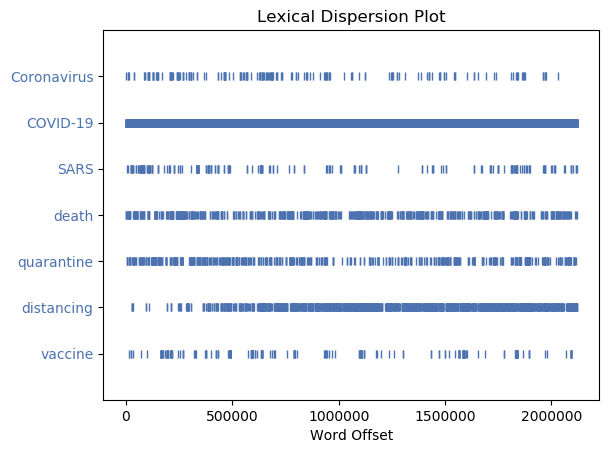

In [444]:
sns.reset_orig()
# Word Offset corespond to news' published timeline
covidText.dispersion_plot(['Coronavirus', 'COVID-19', 'SARS', 'death', 'quarantine', 'distancing', 'vaccine'])

Since I sorted the news by their published date in ascending order, the word offset coresponds to the news' published timeline. This plot is quite informative. We can see 'Coronavirus' was used more in the begining and gradually changed into 'COVID-19'. We can also roughly infer when the concept of 'Social Distance' started to be commonly used from the word 'distance'. 'SARS' was used a lot at the beginning of the outbreak timeline, but it was dropped quite rapidly, signalling that COVID-19 itself became a familiar word. 

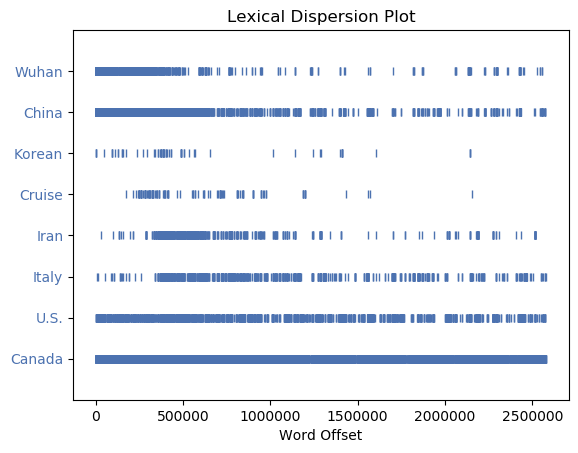

In [297]:
covidText.dispersion_plot(['Wuhan', 'China', 'Korean', 'Cruise', 'Iran', 'Italy', 'U.S.', 'Canada'])
sns.set()

Similar to the first dispersion plot, this plot plotting names of related countries is quite informative.

In [298]:
# generating 100-word text from current corpus
covidText.generate()

Building ngram index...


on COVID-19 This includes teachers students and chaperones heard from
are feeling a great place to ensure that those aboard the cruise line
and we feel are inadequate in prisons given the nature of the
manufacturing power of the most reported cases That becomes a bigger
change for the first four cases in the next regularly scheduled
programming You can walk your dog mouth is the crowd at the RCMP are
following up on the floor that are desperately looking for common
sense right now Or start taking the COVID-19 crisis according to a
Saturday night with performances of traditional


'on COVID-19 This includes teachers students and chaperones heard from\nare feeling a great place to ensure that those aboard the cruise line\nand we feel are inadequate in prisons given the nature of the\nmanufacturing power of the most reported cases That becomes a bigger\nchange for the first four cases in the next regularly scheduled\nprogramming You can walk your dog mouth is the crowd at the RCMP are\nfollowing up on the floor that are desperately looking for common\nsense right now Or start taking the COVID-19 crisis according to a\nSaturday night with performances of traditional'

In [414]:
# combine all text tokens from news before march
covid_token = [element for list_ in covid_news[covid_news['mon'] != 3]['tokenized_text'].values for element in list_ \
              if not element.startswith(("@","&","\'","<","=",">"))]

In [415]:
# counts of interesting tokens
countedWords = wordCounter(covid_token)
countedWords.loc[countedWords['word'].isin(['covid-19', 'coronavirus', 'death', 'china', 'pandemic'])]

,word,count
34,coronavirus,3549
38,china,3024
53,death,298
1660,covid-19,589
3072,pandemic,203


In [301]:
# turn all tokens into NLTK Text and ConcordanceIndex objects
covidText = nltk.Text(covid_token)
covidText.generate()

Building ngram index...


of Asia Milan at a news release Assembly of Manitoba Great Wall
Performing Arts which was developed in wake of the passengers and crew
to 174 Who the Canadian government to increase rapidly as the
government to help them navigate that Cellphones transform Kenyan
commerce Lester said the passengers are coping 5:19 It critical to
make any historical or epidemiological sense Facts vs. fear Experts
offer advice on how long it would remove accounts engaging in those
kinds of groups in a round table discussion with the logistical side
of caution in northern British Columbia according to last year the


'of Asia Milan at a news release Assembly of Manitoba Great Wall\nPerforming Arts which was developed in wake of the passengers and crew\nto 174 Who the Canadian government to increase rapidly as the\ngovernment to help them navigate that Cellphones transform Kenyan\ncommerce Lester said the passengers are coping 5:19 It critical to\nmake any historical or epidemiological sense Facts vs. fear Experts\noffer advice on how long it would remove accounts engaging in those\nkinds of groups in a round table discussion with the logistical side\nof caution in northern British Columbia according to last year the'

In [416]:
# combine all text tokens from news before march
covid_token = [element for list_ in covid_news[covid_news['mon'] == 3]['tokenized_text'].values for element in list_ \
              if not element.startswith(("@","&","\'","<","=",">"))]

In [417]:
# counts of interesting tokens
countedWords = wordCounter(covid_token)
countedWords.loc[countedWords['word'].isin(['covid-19', 'coronavirus', 'death', 'china', 'pandemic'])]

,word,count
19,covid-19,13731
38,coronavirus,5609
369,china,1027
464,death,833
650,pandemic,3176


In [304]:
# turn all tokens into NLTK Text and ConcordanceIndex objects
covidText = nltk.Text(covid_token)
covidText.generate()

Building ngram index...


on COVID-19 This includes staying home when possible and all domestic
flights On Friday morning including a paper titled Coronaphobia Fear
and the Peruvian government has also banned travel in response to the
virus and not the right to refuse work amid COVID-19 concerns COVID-19
Here are some of the country after March break for most of them are
getting very little income for weeks or months 20:29 Trudeau also
confirmed to have been paid by the end of May. But that cuts both ways
they can in an email late last week or so Saghbini had to get all


'on COVID-19 This includes staying home when possible and all domestic\nflights On Friday morning including a paper titled Coronaphobia Fear\nand the Peruvian government has also banned travel in response to the\nvirus and not the right to refuse work amid COVID-19 concerns COVID-19\nHere are some of the country after March break for most of them are\ngetting very little income for weeks or months 20:29 Trudeau also\nconfirmed to have been paid by the end of May. But that cuts both ways\nthey can in an email late last week or so Saghbini had to get all'

# Filtering and normalizing text

As we want to start comparing the different releases we may choose to do a bit of filtering and normalizing that will allow us to focus on what we most care about. We can first make all of the words lower case, then drop the non-word tokens. Next, we can remove some 'stop words', stem the remaining words to remove suffixes, prefixes and (in some languages) infixes, or lemmatize tokens by intelligently grouping inflected or variant forms of the same word (e.g., with a stemmer and a dictionary). 

To begin this process, we will first define a function to work over the tokenized lists, then another to add normalized tokens to a new column.

We will be using spaCy's built in stop words identifying capacity. When we run text through spaCy's language pipeline, it automatically tags it as a stop word. 

We can remove these stopwords from the analysis by fiat, but we could also take a more principled approach by looking at the frequency distribution of words and selecting a specific cut-off associated with the preservation of 'meaningful words' identified upon inspection. Alternatively, we could automatically set a cut-off by rule, such as removal of all words more frequent then the most frequent verb, or the most frequent noun (not pronoun), or some term of central interest. 

In [305]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [306]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that filter, stem and lemmatize the tokens in your corpus, and then creates plots (with titles and labels) that map the word frequency distribution, word probability distribution, and at least two conditional probability distributions that help us better understand the social and cultural game underlying the production of your corpus. Create a wordl of words (or normalized words) and add a few vague comments about what mysteries are revealed through it.</span>

In [307]:
countsDict = {}
for word in covid_token:
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:20]

[('the', 93115),
 ('to', 71179),
 ('of', 49631),
 ('and', 48361),
 ('in', 39553),
 ('a', 35957),
 ('said', 25065),
 ('for', 22234),
 ('is', 21617),
 ('that', 20067),
 ('are', 18705),
 ('on', 17865),
 ('have', 14159),
 ('The', 13983),
 ('COVID-19', 13698),
 ('be', 13572),
 ('with', 13256),
 ('at', 12313),
 ('as', 11248),
 ('it', 11133)]

In [308]:
#The stop list is then all words that occur before the first noun
stop_words_freq = []
for word, count in word_counts:
    if word == 'COVID-19':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

['the',
 'to',
 'of',
 'and',
 'in',
 'a',
 'said',
 'for',
 'is',
 'that',
 'are',
 'on',
 'have',
 'The']

In [309]:
covid_news['normalized_tokens'] = covid_news['tokenized_text'].apply(lambda x: normalizeTokens(x))
covid_news['normalized_tokens_count'] = covid_news['normalized_tokens'].apply(lambda x: len(x))
covid_news['normalized_tokens_POS'] = [spacy_pos(t) for t in covid_news['text']]

In [310]:
covidcfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in covid_news['normalized_tokens_POS'].sum())
covidcpdist_POStoWord = nltk.ConditionalProbDist(covidcfdist_POStoWord, nltk.ELEProbDist)

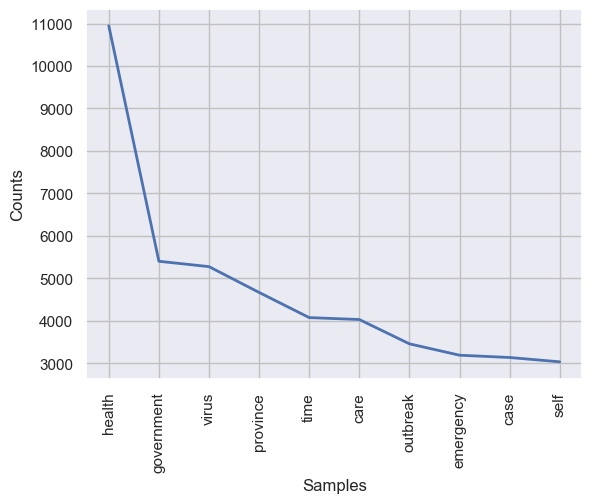

In [311]:
covidcfdist_POStoWord['NN'].plot(10)

In [312]:
covidcpdist_POStoWord['NN'].max()

'health'

In [313]:
covidcpdist_POStoWord['NN'].prob(covidcpdist_POStoWord['NN'].max())

0.0273034520602614

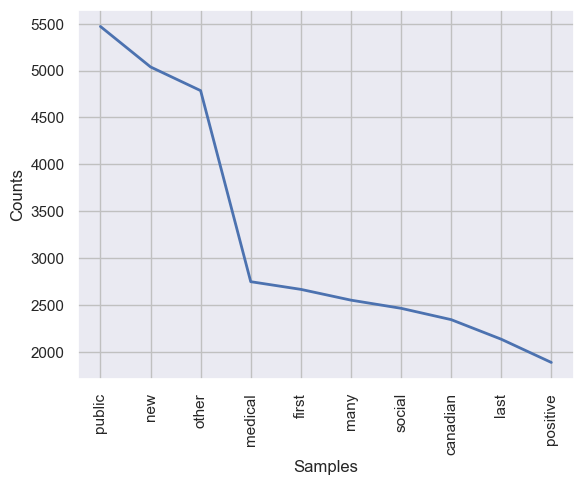

In [314]:
covidcfdist_POStoWord['JJ'].plot(10)

In [315]:
covidcpdist_POStoWord['JJ'].max()

'public'

In [316]:
covidcpdist_POStoWord['JJ'].prob(covidcpdist_POStoWord['JJ'].max())

0.03176386240207134

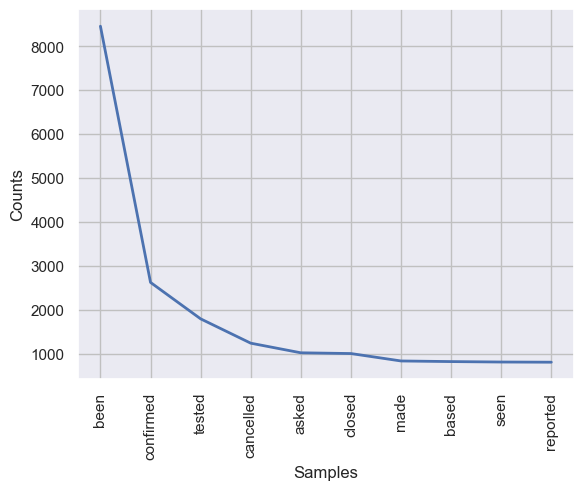

In [317]:
covidcfdist_POStoWord['VBN'].plot(10)

In [318]:
covidcpdist_POStoWord['VBN'].max()

'been'

In [319]:
covidcpdist_POStoWord['VBN'].prob(covidcpdist_POStoWord['VBN'].max())

0.11219470153013869

In [320]:
covid_news['md'] =  covid_news['year'].apply(str) + "-" + covid_news['mon'].apply(str) + "-" + covid_news['day'].apply(str)
covid_news['md'].unique()

array(['2019-12-22', '2020-1-8', '2020-1-9', '2020-1-11', '2020-1-12',
       '2020-1-13', '2020-1-14', '2020-1-15', '2020-1-16', '2020-1-17',
       '2020-1-19', '2020-1-20', '2020-1-21', '2020-1-22', '2020-1-23',
       '2020-1-24', '2020-1-25', '2020-1-26', '2020-1-27', '2020-1-28',
       '2020-1-29', '2020-1-30', '2020-1-31', '2020-2-1', '2020-2-2',
       '2020-2-3', '2020-2-4', '2020-2-5', '2020-2-6', '2020-2-7',
       '2020-2-8', '2020-2-9', '2020-2-10', '2020-2-11', '2020-2-12',
       '2020-2-13', '2020-2-14', '2020-2-15', '2020-2-16', '2020-2-17',
       '2020-2-18', '2020-2-19', '2020-2-20', '2020-2-21', '2020-2-22',
       '2020-2-23', '2020-2-24', '2020-2-25', '2020-2-26', '2020-2-27',
       '2020-2-28', '2020-2-29', '2020-3-1', '2020-3-2', '2020-3-3',
       '2020-3-4', '2020-3-5', '2020-3-6', '2020-3-7', '2020-3-8',
       '2020-3-9', '2020-3-10', '2020-3-11', '2020-3-12', '2020-3-13',
       '2020-3-14', '2020-3-15', '2020-3-16', '2020-3-17', '2020-3-18',
       '202

(-0.5, 1249.5, 1249.5, -0.5)

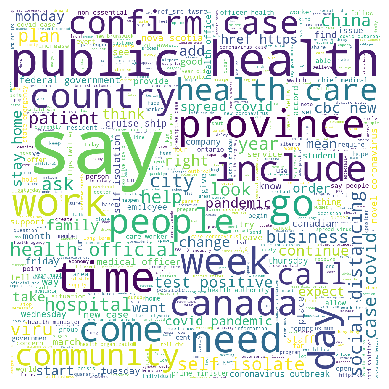

In [403]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 2500, height = 00, 
                         mode ='RGBA', scale=.5).generate(' '.join(covid_news['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")

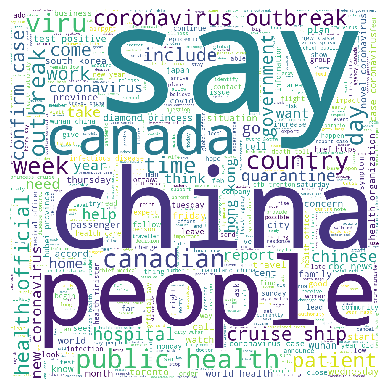

In [421]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 2500, height = 2500, 
                         mode ='RGBA', scale=.5).generate(' '.join(covid_news[covid_news['mon'] != 3]['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("janfeb.png", format = 'png')

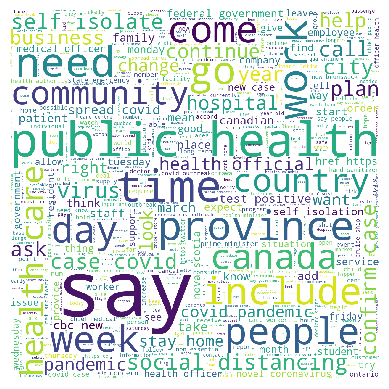

In [420]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 2500, height = 2500, 
                         mode ='RGBA', scale=.5).generate(' '.join(covid_news[covid_news['mon'] == 3]['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("mar.png", format = 'png')

In [326]:
import pandas as pd

# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. We will be using the in-built spaCy pos-tagging.

https://spacy.io/usage/linguistic-features

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

spaCy pos-tags word as we run it through the english language model. A small example:

In [327]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [328]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional associations (e.g., adjectives associated with nouns or adverbs with verbs of interest). What do these distributions suggest about your corpus?

In [329]:
covid_small = covid_news[-50:]
covid_small['sentences'] = covid_small['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
covid_small

/Users/wanitchaya.poon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,year,mon,day,authors,title,description,text,tokenized_title,tokenized_desc,tokenized_text,normalized_tokens,normalized_tokens_count,normalized_tokens_POS,md,sentences
1209,2020,3,26,['Jan Lakes Is A Producer At Cbc Sudbury. You ...,"Now is not the time to start homeschooling, sa...",A Sudbury couple that homeschools their little...,A Sudbury couple that homeschools their little...,"[Now, is, not, the, time, to, start, homeschoo...","[A, Sudbury, couple, that, homeschools, their,...","[A, Sudbury, couple, that, homeschools, their,...","[sudbury, couple, homeschool, little, girl, sa...",196,"[(a, DT), (sudbury, NN), (couple, NN), (that, ...",2020-3-26,"[[A, Sudbury, couple, that, homeschools, their..."
1220,2020,3,26,"['Entertainment Reporter', 'Film Critic', 'Eli...",Free and family friendly: What to watch while ...,"As the push to stay at home continues, some st...",As politicians and public health officials dep...,"[Free, and, family, friendly, What, to, watch,...","[As, the, push, to, stay, at, home, continues,...","[As, politicians, and, public, health, officia...","[politician, public, health, official, deploy,...",537,"[(as, IN), (politicians, NNS), (and, CC), (pub...",2020-3-26,"[[As, politicians, and, public, health, offici..."
1221,2020,3,26,"['Cbc News', ""Terry Roberts Is A Journalist Wi...",Businesses in survival mode need long-term gov...,The association that speaks for many in the Ne...,A group that advocates on behalf of business l...,"[Businesses, in, survival, mode, need, long, t...","[The, association, that, speaks, for, many, in...","[A, group, that, advocates, on, behalf, of, bu...","[group, advocate, behalf, business, leader, wi...",480,"[(a, DT), (group, NN), (that, WDT), (advocates...",2020-3-26,"[[A, group, that, advocates, on, behalf, of, b..."
1223,2020,3,26,[],"British Columbians now face $25K fine, jail if...",The B.C. government has issued a number of ord...,THE LATEST: People who ignore public health o...,"[British, Columbians, now, face, $, 25, K, fin...","[The, B.C., government, has, issued, a, number...","[THE, LATEST, People, who, ignore, public, hea...","[late, people, ignore, public, health, order, ...",529,"[(the, DT), (latest, JJS), (:, :), ( , _SP), (...",2020-3-26,"[[THE, LATEST], [People, who, ignore, public, ..."
1239,2020,3,26,"['Entertainment Reporter', 'Film Critic', 'Eli...",Free and family friendly: What to watch while ...,"As the push to stay at home continues, some st...",As politicians and public health officials dep...,"[Free, and, family, friendly, What, to, watch,...","[As, the, push, to, stay, at, home, continues,...","[As, politicians, and, public, health, officia...","[politician, public, health, official, deploy,...",537,"[(as, IN), (politicians, NNS), (and, CC), (pub...",2020-3-26,"[[As, politicians, and, public, health, offici..."
1273,2020,3,26,[],Bittersweet symphony: Classical musicians conn...,"Keeping a safe distance apart, ESO principal c...",Closed concert halls won't keep some musicians...,"[Bittersweet, symphony, Classical, musicians, ...","[Keeping, a, safe, distance, apart, ESO, princ...","[Closed, concert, halls, wo, n't, keep, some, ...","[closed, concert, hall, wo, musician, perform,...",174,"[(closed, NNP), (concert, NNP), (halls, NNS), ...",2020-3-26,"[[Closed, concert, halls, wo, n't, keep, some,..."
1283,2020,3,26,[],Inmate with COVID-19 admitted to Toronto South...,An inmate at the Toronto South Detention Centr...,An inmate was admitted to Ontario's largest ja...,"[Inmate, with, COVID-19, admitted, to, Toronto...","[An, inmate, at, the, Toronto, South, Detentio...","[An, inmate, was, admitted, to, Ontario, 's, l...","[inmate, admit, ontario, large, jail, test, po...",549,"[(an, DT), (inmate, NN), (was, VBD), (admitted...",2020-3-26,"[[An, inmate, was, admitted, to, Ontario, 's, ..."
1352,2020,3,26,[],What does COVID-19 mean for your civil liberti...,When it comes to enforcing self-isolation rule...,When it comes to enforcing self-isolation rule...,"[

In [330]:
covid_small['POS_sents'] = covid_small['sentences'].apply(lambda x: tag_sents_pos(x))

/Users/wanitchaya.poon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [331]:
covid_small['POS_sents'][:10]

1209    [[(A, DT), (Sudbury, NNP), (couple, NN), (that...
1220    [[(As, IN), (politicians, NNS), (and, CC), (pu...
1221    [[(A, DT), (group, NN), (that, WDT), (advocate...
1223    [[(THE, DT), (LATEST, NNP), (People, NNS), (wh...
1239    [[(As, IN), (politicians, NNS), (and, CC), (pu...
1273    [[(Closed, NNP), (concert, NN), (halls, NNS), ...
1283    [[(An, DT), (inmate, NN), (was, VBD), (admitte...
1352    [[(When, WRB), (it, PRP), (comes, VBZ), (to, I...
0       [[(Canadian, JJ), (pharmacies, NNS), (are, VBP...
1       [[(The, DT), (Yukon, NNP), (government, NN), (...
Name: POS_sents, dtype: object

In [332]:
countTarget = 'NN'
targetCounts = {}
for entry in covid_small['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('health', 139),
 ('government', 72),
 ('province', 65),
 ('emergency', 60),
 ('care', 58),
 ('pandemic', 56),
 ('time', 56),
 ('COVID-19', 50),
 ('week', 46),
 ('spread', 44),
 ('number', 42),
 ('cent', 42),
 ('testing', 41),
 ('community', 39),
 ('staff', 39),
 ('virus', 39),
 ('home', 38),
 ('isolation', 37),
 ('work', 36),
 ('self', 36)]

In [424]:
NTarget = 'JJ'
Word = 'isolation'
NResults = set()
for entry in covid_small['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)    

{'medical', 'acute', 'social'}


In [426]:
NTarget = 'JJ'
Word = 'pandemic'
NResults = set()
for entry in covid_small['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)  

{'COVID-19', 'global', 'current', 'prolonged', 'other', 'deadly', 'unified', 'communitiesIndigenous', 'whole'}


In [425]:
NTarget = 'JJ'
Word = 'work'
NResults = set()
for entry in covid_small['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)  

{'online', 'unsafe'}


In [334]:
countTarget = 'VB'
targetCounts = {}
for entry in covid_small['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('be', 220),
 ('have', 55),
 ('help', 44),
 ('do', 36),
 ('get', 28),
 ('come', 27),
 ('take', 25),
 ('make', 25),
 ('keep', 25),
 ('go', 24),
 ('see', 22),
 ('ensure', 19),
 ('continue', 19),
 ('provide', 18),
 ('stay', 17),
 ('reduce', 17),
 ('isolate', 16),
 ('use', 15),
 ('call', 15),
 ('work', 13)]

In [440]:
NTarget = 'RB'
Word = 'stay'
NResults = set()
for entry in covid_small['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)    

{'seriously'}


In [438]:
NTarget = 'RB'
Word = 'come'
NResults = set()
for entry in covid_small['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'never', "n't", 'far'}


In [336]:
countTarget = 'JJ'
targetCounts = {}
for entry in covid_small['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('COVID-19', 155),
 ('public', 63),
 ('other', 62),
 ('new', 47),
 ('pandemic', 45),
 ('essential', 41),
 ('many', 37),
 ('social', 35),
 ('federal', 34),
 ('last', 32),
 ('positive', 31),
 ('such', 30),
 ('medical', 30),
 ('provincial', 27),
 ('local', 26),
 ('safe', 26),
 ('possible', 22),
 ('good', 21),
 ('available', 20),
 ('different', 18)]

# Collocations

As illustrated above, we might want to find significant bigrams (two-word phrases), trigrams (three-word phrases), n-grams (*n*-word phrases) or skip-grams (noncontinguous 'phrases' with skip-length *n*). 

We will begin with the [`nltk.collocations.BigramCollocationFinder`](http://www.nltk.org/api/nltk.html?highlight=bigramcollocationfinder#nltk.collocations.BigramCollocationFinder) class, which can be given raw lists of strings with the `from_words()` method. By default it only looks at continuous bigrams but there is an option (`window_size`) to allow skip-grams.

To compare the bigrams we need to tell nltk what our score function is. Initially, we will look at the raw counts.

In [337]:
def bigramScoring(count, wordsTuple, total):
    return count

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that identify statistically significant bigrams, trigrams, quadgrams, higher-order *n*grams and skipgrams. Explore whether these collocations are idiomatic and so irreducible to the semantic sum of their component words. You can do this by examination of conditional frequencies (e.g., what else is 'united' besides the 'United States'). If these phrases are idiomatic, what do they suggest about the culture of the world producing them?

<span style="color:red">**Stretch**: In Manning and Schütze's textbook, there Section 5.3.2 explores how to use the *t*-test to find words whose co-occurance patterns best distinguish two words. Implement that and use it to explore phrases in your corpus. For instance, you could tell what words come after "America" much more often than after "Iraq"?</span> 

In [338]:
covidBigrams = nltk.collocations.BigramCollocationFinder.from_words(covid_news['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(covidBigrams.N))

There are 1349843 bigrams in the finder


In [339]:
print(covidBigrams.nbest(bigramScoring, 20))

[('public', 'health'), ('confirm', 'case'), ('health', 'care'), ('health', 'official'), ('social', 'distancing'), ('self', 'isolate'), ('case', 'covid-19'), ('test', 'positive'), ('cbc', 'news'), ('stay', 'home'), ('covid-19', 'pandemic'), ('federal', 'government'), ('novel', 'coronavirus'), ('spread', 'covid-19'), ('new', 'case'), ('cruise', 'ship'), ('medical', 'officer'), ('self', 'isolation'), ('nova', 'scotia'), ('coronavirus', 'outbreak')]


In [340]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
covidBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:20]

[(('public', 'health'), 27052.23702495003),
 (('social', 'distancing'), 18220.862341704884),
 (('self', 'isolate'), 15354.617105115958),
 (('nova', 'scotia'), 14499.976686342889),
 (('confirm', 'case'), 12602.615422991677),
 (('test', 'positive'), 12269.555855391205),
 (('cruise', 'ship'), 11732.10978958306),
 (('prime', 'minister'), 10524.681847566744),
 (('cbc', 'news'), 10231.33231005137),
 (('novel', 'coronavirus'), 9918.667478845373),
 (('health', 'care'), 9870.203853209963),
 (('self', 'isolation'), 9698.775667829035),
 (('health', 'official'), 9497.422609450383),
 (('medical', 'officer'), 9285.00717053524),
 (('<', 'href="https://twitter.com'), 9125.40005090606),
 (('stay', 'home'), 9105.99228928804),
 (('federal', 'government'), 8905.50339755439),
 (('hand', 'sanitizer'), 7825.554025037788),
 (('non', 'essential'), 7794.456220474392),
 (('hong', 'kong'), 7111.655775934264)]

In [341]:
covidTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(covid_news['normalized_tokens'].sum())
print("There are {} trigrams in the finder".format(covidTrigrams.N))

There are 1349843 trigrams in the finder


In [342]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
covidTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('medical', 'officer', 'health'), 27.746801166454418),
 (('health', 'care', 'worker'), 25.72449691091411),
 (('chief', 'medical', 'officer'), 25.159185378288257),
 (('world', 'health', 'organization'), 24.938907795505038),
 (('public', 'health', 'official'), 23.866189794004146),
 (('public', 'health', 'officer'), 22.75385685688032),
 (('chief', 'public', 'health'), 22.31093552715719),
 (('=', 'hash&amp;ref_src', '='), 21.236746065488905),
 (('prime', 'minister', 'justin'), 20.760504576035608),
 (('minister', 'justin', 'trudeau'), 20.760493193908584),
 (('tell', 'cbc', 'news'), 20.566070489679078),
 (('<', 'href="https://twitter.com', 'hashtag'), 20.493892806533935),
 (('test', 'positive', 'covid-19'), 20.14590237972681),
 (('confirm', 'case', 'covid-19'), 20.13366906289633),
 (('health', 'officer', 'dr'), 19.413776398502165),
 (('long', 'term', 'care'), 19.183096119653378),
 (('public', 'health', 'agency'), 19.128019054923474),
 (('declare', 'state', 'emergency'), 18.27546579851992),

In [343]:
Ngrams = nltk.ngrams(covid_news['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1

In [344]:
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 150:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('public', 'health', 'agency', 'canada'): 304, ('canada', 'chief', 'public', 'health'): 176, ('chief', 'public', 'health', 'officer'): 455, ('public', 'health', 'officer', 'dr'): 154, ('chief', 'medical', 'officer', 'health'): 437, ('medical', 'officer', 'health', 'dr'): 195, ('avoid', 'touch', 'eye', 'nose'): 153, ('touch', 'eye', 'nose', 'mouth'): 162, ('prime', 'minister', 'justin', 'trudeau'): 431, ('medical', 'officer', 'health', 'say'): 164, ('long', 'term', 'care', 'home'): 163, ('health', 'officer', 'dr', 'bonnie'): 178, ('officer', 'dr', 'bonnie', 'henry'): 178, ('provincial', 'health', 'officer', 'dr'): 171}


In [345]:
Ngrams = nltk.ngrams(covid_news['normalized_tokens'].sum(), 6)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1

In [346]:
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 125:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('provincial', 'health', 'officer', 'dr', 'bonnie', 'henry'): 165, ('fever', 'cough', 'tiredness', 'symptom', 'develop', 'include'): 128, ('cough', 'tiredness', 'symptom', 'develop', 'include', 'difficulty'): 128, ('tiredness', 'symptom', 'develop', 'include', 'difficulty', 'breathing'): 128, ('symptom', 'develop', 'include', 'difficulty', 'breathing', 'pneumonia'): 128, ('visit', 'emergency', 'room', 'urgent', 'care', 'centre'): 128, ('emergency', 'room', 'urgent', 'care', 'centre', 'test'): 128, ('detailed', 'information', 'outbreak', 'available', 'federal', 'government'): 127, ('information', 'outbreak', 'available', 'federal', 'government', 'website'): 127}


In [347]:
skipgrams = nltk.skipgrams(covid_news['normalized_tokens'].sum(), 2, 2)
Counts = {}
for ngram in list(skipgrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1

In [348]:
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 1000:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('cbc', 'news'): 1243, ('federal', 'government'): 1094, ('coronavirus', 'outbreak'): 1013, ('health', 'say'): 1955, ('new', 'case'): 1363, ('say', 'people'): 1614, ('public', 'health'): 3964, ('health', 'official'): 1710, ('novel', 'coronavirus'): 1036, ('say', 'say'): 1061, ('health', 'care'): 1805, ('confirm', 'case'): 2456, ('test', 'positive'): 1325, ('spread', 'covid-19'): 1084, ('cruise', 'ship'): 1018, ('chief', 'health'): 1088, ('chief', 'officer'): 1314, ('medical', 'officer'): 1088, ('stay', 'home'): 1212, ('covid-19', 'case'): 1042, ('self', 'isolate'): 1429, ('case', 'covid-19'): 1535, ('covid-19', 'pandemic'): 1157, ('social', 'distancing'): 1472}


# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects. 
Like every other part of the pipeline, spaCy also tags words with their tagged entity (https://spacy.io/api/entityrecognizer). You can see the full capacity of what spaCy does by checking out: https://spacy.io/usage/linguistic-features.

For training the identification of such entities, spaCy uses a deep learning model.

In [349]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed.

In [350]:
covid_small['classified_sents'] = covid_small['sentences'].apply(lambda x: tag_sents_ner(x))

/Users/wanitchaya.poon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


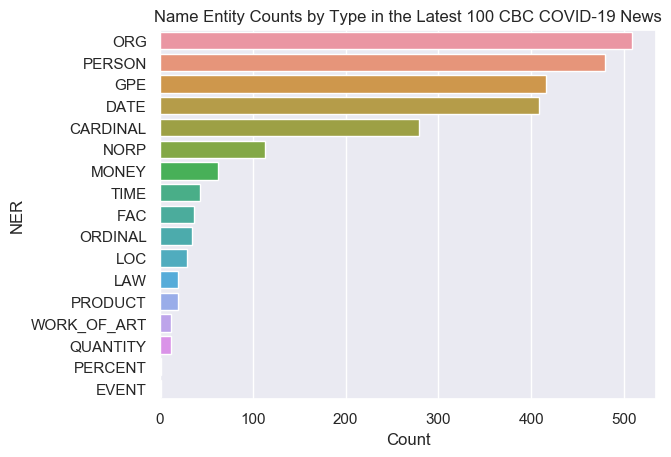

In [351]:
NERCounts = {}
for entry in covid_small['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind in NERCounts:
                NERCounts[kind] += 1
            else:
                NERCounts[kind] = 1
sortedNER = sorted(NERCounts.items(), key = lambda x: x[1], reverse = True)
df = pandas.DataFrame(sortedNER)
df.rename(columns={0: "NER", 1: "Count"}, inplace = True)
p = sns.barplot(df['Count'], df['NER'])
p.set_title("Name Entity Counts by Type in the Latest 100 CBC COVID-19 News");

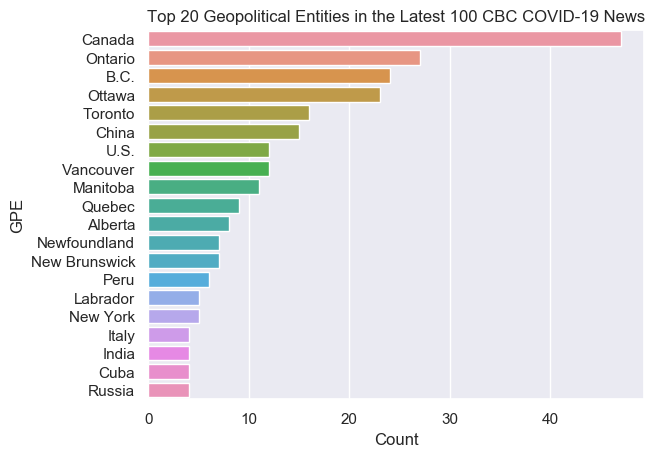

In [352]:
GPECounts = {}
for entry in covid_small['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'GPE':
                if ent in GPECounts:
                    GPECounts[ent] += 1
                else:
                    GPECounts[ent] = 1
sortedGPE = sorted(GPECounts.items(), key = lambda x: x[1], reverse = True)
df = pandas.DataFrame(sortedGPE[:20])
df.rename(columns={0: "GPE", 1: "Count"}, inplace = True)
p = sns.barplot(df['Count'], df['GPE'])
p.set_title("Top 20 Geopolitical Entities in the Latest 100 CBC COVID-19 News");

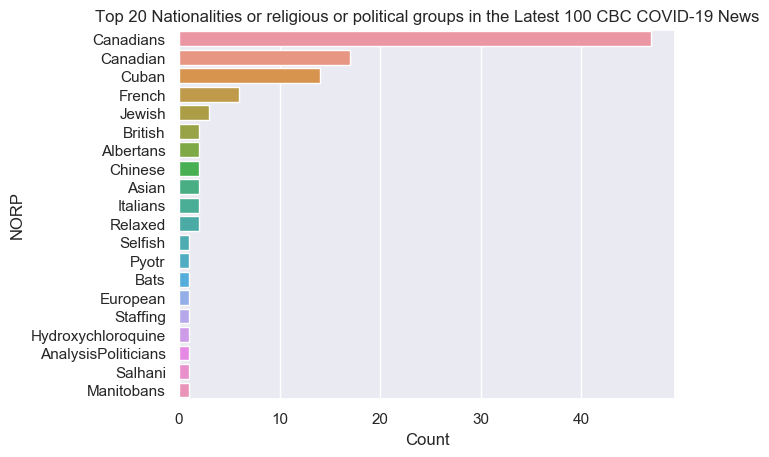

In [353]:
NORPCounts = {}
for entry in covid_small['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'NORP':
                if ent in NORPCounts:
                    NORPCounts[ent] += 1
                else:
                    NORPCounts[ent] = 1
sortedNORP = sorted(NORPCounts.items(), key = lambda x: x[1], reverse = True)
df = pandas.DataFrame(sortedNORP[:20])
df.rename(columns={0: "NORP", 1: "Count"}, inplace = True)
p = sns.barplot(df['Count'], df['NORP'])
p.set_title("Top 20 Nationalities or religious or political groups in the Latest 100 CBC COVID-19 News");

## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

We will be using spaCy's built in dependancy parser to go about exploring the tree.
Note that unlike previous examples, large corpuses or collections of sentences don't give us as much information, so we will be navigating smaller sentences.

Let us start by exploring noun chunks. Noun chunks are “base noun phrases” – flat phrases that have a noun as their head. You can think of noun chunks as a noun plus the words describing the noun – for example, “the lavish green grass” or “the world’s largest tech fund”. To get the noun chunks in a document, simply iterate over the sentences noun chunks.

In [354]:
from spacy import displacy

spaCy uses the terms head and child to describe the words connected by a single arc in the dependency tree. The term dep is used for the arc label, which describes the type of syntactic relation that connects the child to the head. As with other attributes, the value of .dep is a hash value. You can get the string value with .dep_.

For your reference:

Text: The original token text.

Dep: The syntactic relation connecting child to head.

Head text: The original text of the token head.

Head POS: The part-of-speech tag of the token head.

Children: The immediate syntactic dependents of the token.

In [355]:
from spacy.symbols import nsubj, VERB

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceive to play in the social world inscribed by your texts?

In [356]:
doc = nlp(" ".join(covid_small['sentences'][0][0]))
displacy.render(doc, style='dep')

In [357]:
for chunk in doc.noun_chunks:
    print(chunk.text, "-", chunk.root.text, "-", chunk.root.dep_, "-", chunk.root.head.text)

Canadian pharmacies - pharmacies - nsubj - limiting
how much medication - medication - nsubjpass - dispensed
shortages - shortages - dobj - prevent
most active ingredients - ingredients - nsubj - come
drugs - drugs - pobj - for
India - India - pobj - from
China and medical supply chains - chains - conj - India
the spread - spread - pobj - by
COVID-19 - COVID-19 - pobj - of


In [358]:
for token in doc:
    print(token.text, "-", token.dep_, "-", token.head.text, "-", token.head.pos_, "-", 
            [child for child in token.children])

Canadian - amod - pharmacies - NOUN - []
pharmacies - nsubj - limiting - VERB - [Canadian]
are - aux - limiting - VERB - []
limiting - ROOT - limiting - VERB - [pharmacies, are, dispensed, disrupted]
how - advmod - much - ADJ - []
much - amod - medication - NOUN - [how]
medication - nsubjpass - dispensed - VERB - [much]
can - aux - dispensed - VERB - []
be - auxpass - dispensed - VERB - []
dispensed - ccomp - limiting - VERB - [medication, can, be, try]
to - aux - try - VERB - []
try - xcomp - dispensed - VERB - [to, prevent]
to - aux - prevent - VERB - []
prevent - xcomp - try - VERB - [to, shortages]
shortages - dobj - prevent - VERB - [recognizing]
recognizing - acl - shortages - NOUN - [come]
that - mark - come - VERB - []
most - advmod - active - ADJ - []
active - amod - ingredients - NOUN - [most]
ingredients - nsubj - come - VERB - [active, for]
for - prep - ingredients - NOUN - [drugs]
drugs - pobj - for - ADP - []
come - ccomp - recognizing - VERB - [that, ingredients, from]
f

In [359]:
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{limiting, come}


In [360]:
print(doc[3])
print([token.text for token in doc[3].lefts]) 
print([token.text for token in doc[3].rights])  

limiting
['pharmacies', 'are']
['dispensed', 'disrupted']


In [361]:
root = [token for token in doc if token.head == token][0]
print(root)
subject = list(root.lefts)[0]
for descendant in subject.subtree:
    assert subject is descendant or subject.is_ancestor(descendant)
    print(descendant.text, "-", descendant.dep_, "-", descendant.n_lefts, "-", 
            descendant.n_rights, "-", 
            [ancestor.text for ancestor in descendant.ancestors])

limiting
Canadian - amod - 0 - 0 - ['pharmacies', 'limiting']
pharmacies - nsubj - 1 - 0 - ['limiting']


In [362]:
stop = []
for index, row in covid_small.iterrows():
    text = ' '.join(row['tokenized_text'])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        if chunk.root.head.text == 'stopped' or chunk.root.head.text == 'stop':
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0 or object_ is not 0:
                stop.append((subject, object_))
stop

[('workers', 0),
 (0, 'people'),
 ('hospitals', 0),
 ('work', 0),
 ('us', 0),
 (0, 'WATCH'),
 (0, 'spread'),
 (0, 'spread'),
 ('we', 0),
 (0, 'pandemic'),
 (0, 'them'),
 (0, 'spread'),
 ('he', 0),
 ('he', 0)]

In [448]:
stop = []
for index, row in covid_small.iterrows():
    text = ' '.join(row['tokenized_text'])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        if chunk.root.head.text == 'die' or chunk.root.head.text == 'died':
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0 or object_ is not 0:
                stop.append((subject, object_))
stop

[(0, 'Quebecers'), ('patients', 0), ('people', 0)]

In [363]:
spread = []
for index, row in covid_small.iterrows():
    text = ' '.join(row['tokenized_text'])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        if chunk.root.head.text == 'spread' or chunk.root.head.text == 'spreaded':
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0 or object_ is not 0:
                spread.append((subject, object_))
spread

[('it', 0),
 ('it', 0),
 ('virus', 0),
 ('SARS', 0),
 ('virus', 0),
 (0, 'load'),
 ('who', 0),
 (0, 'it'),
 ('Community', 0),
 ('virus', 0)]

# Distributional distances

If we want to compare different corpora, we need a distance or divergence that compares the two distributions.

We will use the: 

+ Kullback-Leibler (KL) divergence
+ $\chi^2$ divergence
+ Kolmogorov-Smirnov (KS) distance
+ Wasserstein distance

### Kullback-Leibler and $x^2$ divergences ###

KL and $\chi^2$ divergences are members of the broader <a "href=https://en.wikipedia.org/wiki/F-divergence" target="_blank">$f$-divergence</a> family, a function of $D_f (P || Q)$ that calculates the difference between two probability distributions P and Q. The KL $f(t)$ is $ t \text{ log } t $, while the $\chi^2$ is $t^2-1$. KL comes from information and $\chi^2$ from measure theory. As such, the KL divergence computes the relative entropy between two distributions--how they differ in bits, while the $\chi^2$ whether the same statistical inferences can be drawn from them both.  

Specifically, given two discrete probability distributions $P$ and $Q$, the Kullback-Leibler divergence from $Q$ to $P$ is defined as:

$D_{\mathrm{KL}}(P\|Q) = \sum_i P(i) \, \log\frac{P(i)}{Q(i)}$.

The [scipy.stats.entropy()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) function does the calculation for you, which takes in two arrays of probabilities and computes the KL divergence. Note that the KL divergence is in general not commutative, i.e. $D_{\mathrm{KL}}(P\|Q) \neq D_{\mathrm{KL}}(Q\|P)$ .

Also note that the KL divernce is the sum of elementwise divergences. Scipy provides [scipy.special.kl_div()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html#scipy-special-kl-div) which calculates elementwise divergences for you.

The $\chi^2$ Divergence is defined as:

$D_{\mathrm{\chi^2}}(P\|Q) = \sum_i \left(\frac{P(i)}{Q(i)}-1\right)^2$. 

This is also noncommutative, and the code can be drawn directly from scipy.

### Kolmogorov-Smirnov ###

The two-sample Kolmogovorov-Smirnov test statistic calculates the distance between the cumulative distribution function of the two distributions to be compared, and, along with the $x^2$ divergence, is among the most common approaches two calculating a distance in statistics. It can be interpreted as a test of whether two distributions are drawn from the same underlying distribution. As with the others, the code is readily available in scipy.

### Wasserstein Distance ###

When this is computed on a Euclidian metric structure (e.g., numbers of words), this is also known as the earth mover’s distance, because it can be seen as the minimum amount of "work" required to transform $P$ into $Q$, where "work" is measured as the amount of distribution weight that must be moved, multiplied by the distance it has to be moved.

In [364]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

In [365]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

## <span style="color:red">*Exercise 6*</span>

<span style="color:red">Construct cells immediately below this that calculate the KL and $\chi^2$ divergences, and the KS and Wasserstein distances between four separate corpora, plot these with heatmaps, and then array them in two dimensions with multidimensional scaling as above. What does this reveal about relations between the corpora? Which analysis (and divergence or distribution) distinguishes the authors or documents better? 

<span style="color:red">**Stretch**: Calculate the <a "href=https://en.wikipedia.org/wiki/Jensen–Shannon_divergence" target="_blank">Jensen-Shannon Divergence</a> between your four corpora. What is the relationship between the KL and JS divergences?</span> 

In [366]:
mar = covid_news[covid_news['mon'] == 3]

In [367]:
early = covid_news[covid_news['mon'] != 3]

In [368]:
jan = covid_news[covid_news['mon'] == 1]

In [369]:
feb = covid_news[covid_news['mon'] == 2]

In [370]:
marWords = set(mar['normalized_tokens'].sum())
earlyWords = set(early['normalized_tokens'].sum())
overlapWords = marWords & earlyWords
overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}

In [371]:
overlapWords

{'smith',
 'azerbaijan',
 'unscrupulous',
 'number',
 'hydro',
 'infective',
 'abel',
 'monetary',
 'mild',
 'regina',
 'annie',
 'mitt',
 'fifth',
 'doorstep',
 'readjust',
 'partisanship',
 'isle',
 'krista',
 'manufacturing',
 'sardine',
 'somali',
 'antibody',
 'stuck',
 'chang',
 'munk',
 'poisson',
 'fears',
 'oncologist',
 'continent',
 'hamilton',
 'heap',
 'bleed',
 'bubble',
 'guan',
 'moderate',
 'trundle',
 'quigley',
 'march',
 'intermediate',
 'prospect',
 'footprint',
 'en',
 'understand',
 'hour',
 'trophy',
 'promptly',
 'quarantine',
 'drag',
 'gregory',
 'rest',
 'kaushic',
 'savvy',
 'alaa',
 'comparable',
 'reminiscent',
 'rebecca',
 'use',
 'mechanical',
 'luther',
 'kyle',
 'stroke',
 'koreans',
 '2019-ncov',
 'dent',
 'lose',
 'detrimental',
 'flat',
 'afford',
 'pellet',
 'merchandise',
 'accumulate',
 'respondent',
 'aggressively',
 'grill',
 'hoption',
 'physiotherapist',
 '2:25',
 'u.k',
 'ghana',
 'table',
 'similar',
 'say',
 'hearing',
 'costa',
 'nenshi'

In [372]:
marProbArray = makeProbsArray(mar['normalized_tokens'], overlapWordsDict)
earlyProbArray = makeProbsArray(early['normalized_tokens'], overlapWordsDict)

In [373]:
mar_earlyDivergence = scipy.stats.entropy(marProbArray, earlyProbArray)
print (mar_earlyDivergence)
early_marDivergence = scipy.stats.entropy(earlyProbArray, marProbArray)
print (early_marDivergence)

0.3027757385885822
0.3457351394388619


In [374]:
mar_earlyDivergence_ew = scipy.special.kl_div(marProbArray, earlyProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = mar_earlyDivergence_ew
kl_df.sort_values(by='elementwise divergence', ascending=False)[:20]

,word,elementwise divergence
380,covid-19,0.011446
4943,china,0.009259
6263,distancing,0.005921
6290,wuhan,0.005079
7627,coronavirus,0.004063
310,chinese,0.003573
37,march,0.003045
46,quarantine,0.002672
4583,outbreak,0.002274
7824,service,0.002041


In [375]:
janWords = set(jan['normalized_tokens'].sum())
febWords = set(jan['normalized_tokens'].sum())
overlapWords = janWords & febWords
overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}

In [376]:
janProbArray = makeProbsArray(jan['normalized_tokens'], overlapWordsDict)
febProbArray = makeProbsArray(feb['normalized_tokens'], overlapWordsDict)

In [377]:
jan_febDivergence = scipy.stats.entropy(janProbArray, febProbArray)
print (jan_febDivergence)
feb_janDivergence = scipy.stats.entropy(febProbArray, janProbArray)
print (feb_janDivergence)

inf
0.27472254734852924


In [378]:
feb_janDivergence_ew = scipy.special.kl_div(febProbArray, janProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = feb_janDivergence_ew
kl_df.sort_values(by='elementwise divergence', ascending=False)[:20]

,word,elementwise divergence
1171,ship,0.014192
2981,cruise,0.013383
4544,princess,0.007050
5954,iran,0.004389
238,covid-19,0.004056
28,quarantine,0.003955
419,italy,0.002358
601,passenger,0.002238
3356,crew,0.002131
2742,sars,0.001908


In [379]:
corpora = []
for index, row in early.iterrows():
    if len(corpora) > 30:
        break
    corpora.append(row['tokenized_text'])

In [380]:
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    corpora_s.append(s)
    corpora_nons.append(nons)

In [381]:
fileids = list(early['md'])[0:31]

In [382]:
index = [i for i in range(31)]

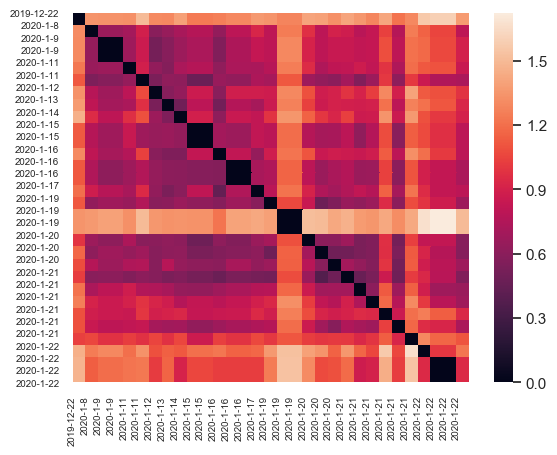

In [383]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.xticks(index, fileids, size = 7)
plt.yticks(index, fileids, size = 7)
plt.show()

/Users/wanitchaya.poon/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


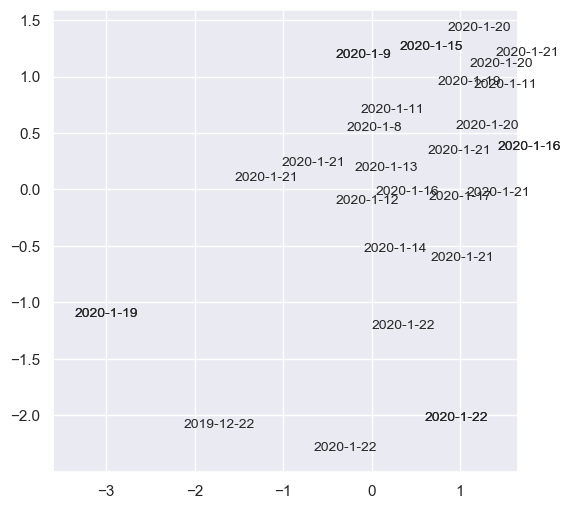

In [384]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]), size = 10)

In [487]:
covid_news[covid_news['md'] == '2020-1-19']['text'].iloc[1]

'As always, CBC Ottawa\'s reporters were out this past week capturing all the goings-on in the region. This week\xa0they met the young stars of a new awareness campaign, sat down with\xa0a group of men affected by the city\'s "housing emergency" and spoke to Ottawans with family trapped overseas by the coronavirus outbreak.\xa0 Here are some of the highlights: This week Ottawa became the first city in the country to declare a housing and homelessness emergency. Ed Campbell, 68, is moving to Prescott, Ont., to find somewhere to live.  (Matthew Kupfer/CBC ) \'Broke on payday\': Facing eviction, longtime tenants feeling Ottawa\'s housing squeeze firsthand City declares housing emergency Amelia Watson, 8, is part of an advertisement campaign on OC Transpo buses in Ottawa to raise awareness of Tourette Syndrome. (Laura Glowacki/CBC) Tourette campaign shows syndrome\'s younger face This was the first weekend of Winterlude. Snow sculptors were at work in Gatineau\'s Jacques-Cartier Park. (Ian

In [501]:
set(covid_news[covid_news['md'] == '2020-1-22']['title'])

{'B.C. health officials prepare coronavirus diagnostic test, screen at airports',
 'Death toll from new coronavirus outbreak in China reaches 17',
 'Get informed on the top stories of the day in one quick scan',
 'How Canadian hospitals and airports are preparing for new coronavirus',
 'Key things to watch for in the coronavirus outbreak',
 "Nova Scotians don't need to be 'overly concerned' with coronavirus, says top health official",
 "Risk of new coronavirus spreading to the North low, say territories' top doctors",
 'Sask. hospitals put protocol in place to spot potential coronavirus cases',
 'Thunder Bay health unit monitoring coronavirus situation',
 'WHO postpones decision on whether to declare emergency over coronavirus'}

In [502]:
set(covid_news[covid_news['md'] == '2020-1-21']['title'])

{'Alberta doctors advised to watch for new coronavirus as 1st North American case diagnosed',
 'Get informed on the top stories of the day in one quick scan',
 'Sask. researchers aiming to develop a vaccine for coronavirus outbreak in China',
 'Stock markets down on growing concern about coronavirus in China',
 'Trudeau airport, Quebec hospitals take precautionary measures over coronavirus',
 'U.S. officials confirm first U.S. case of China coronavirus'}

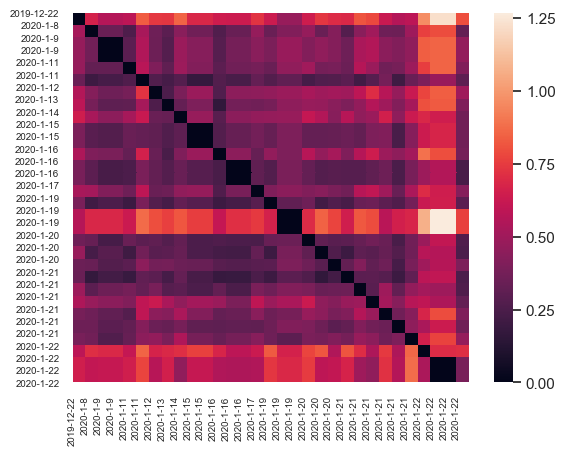

In [385]:
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.xticks(index, fileids, size = 7)
plt.yticks(index, fileids, size = 7)
plt.show()

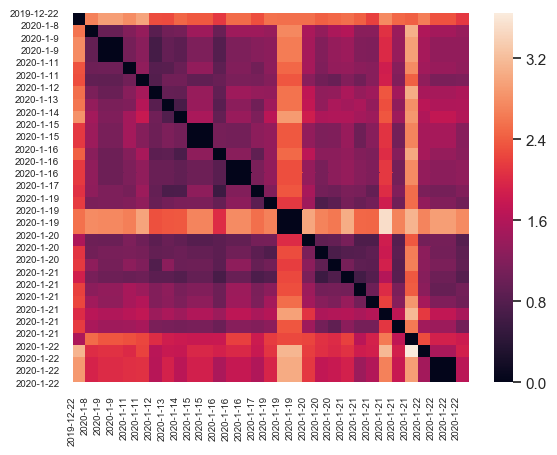

In [386]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.xticks(index, fileids, size = 7)
plt.yticks(index, fileids, size = 7)
plt.show()

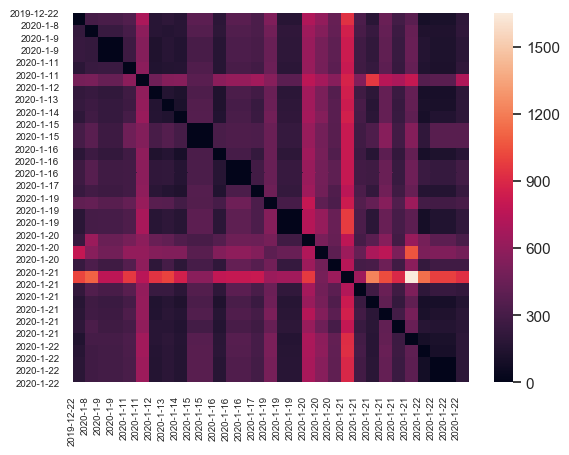

In [387]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.xticks(index, fileids, size = 7)
plt.yticks(index, fileids, size = 7)
plt.show()

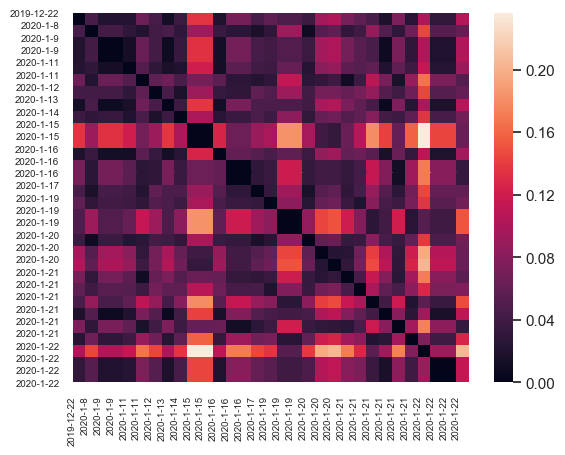

In [388]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.xticks(index, fileids, size = 7)
plt.yticks(index, fileids, size = 7)
plt.show()

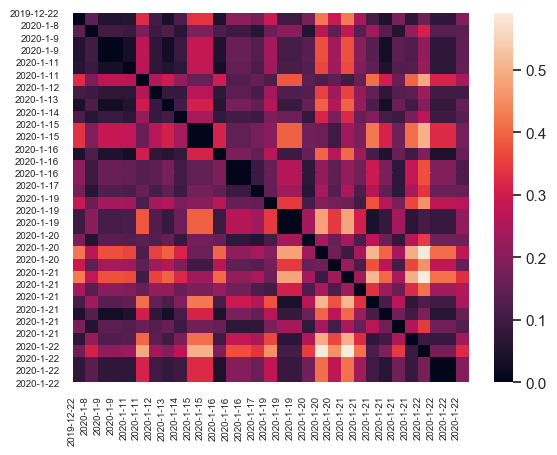

In [389]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.xticks(index, fileids, size = 7)
plt.yticks(index, fileids, size = 7)
plt.show()

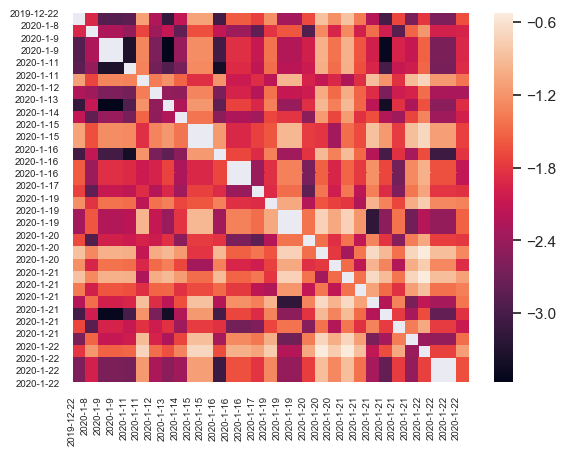

In [390]:
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.xticks(index, fileids, size = 7)
plt.yticks(index, fileids, size = 7)
plt.show()

In [391]:
corpora = []
for index, row in early[::-1].iterrows():
    if len(corpora) > 30:
        break
    corpora.append(row['tokenized_text'])

In [392]:
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    corpora_s.append(s)
    corpora_nons.append(nons)

In [393]:
fileids = list(early[::-1]['md'])[0:31]

In [394]:
index = [i for i in range(31)]

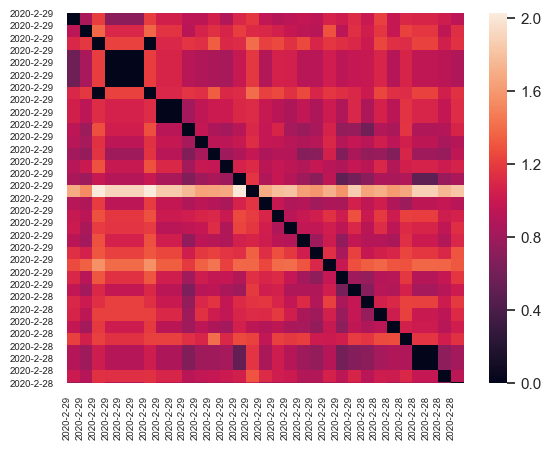

In [395]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.xticks(index, fileids, size = 7)
plt.yticks(index, fileids, size = 7)
plt.show()

/Users/wanitchaya.poon/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


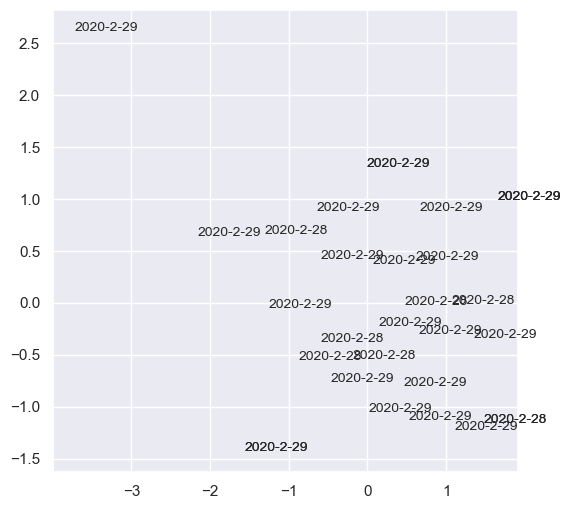

In [396]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]), size = 10)

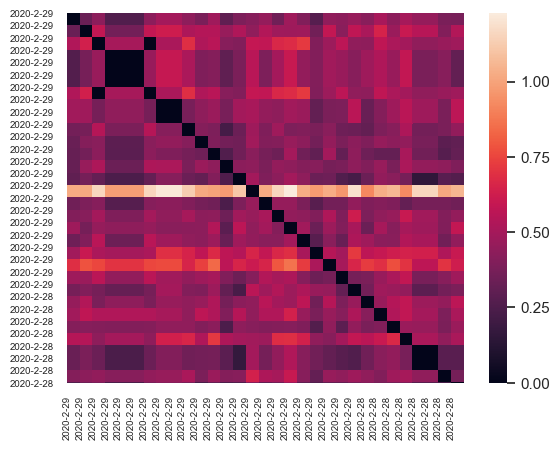

In [397]:
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.xticks(index, fileids, size = 7)
plt.yticks(index, fileids, size = 7)
plt.show()

In [496]:
early[::-1][:15].iloc[-1]['title']

'While Winnipeg travellers worry about coronavirus, common illnesses are more likely to ruin a holiday'

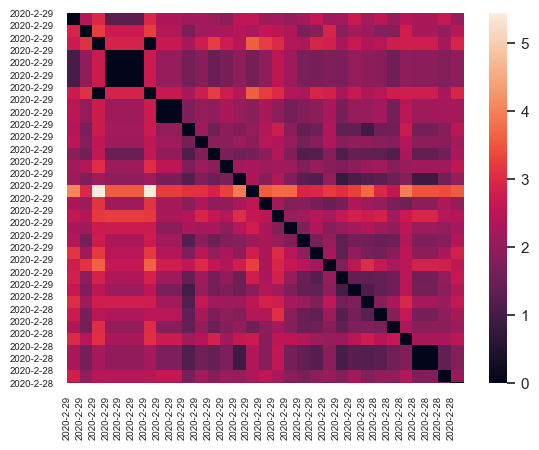

In [398]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.xticks(index, fileids, size = 7)
plt.yticks(index, fileids, size = 7)
plt.show()

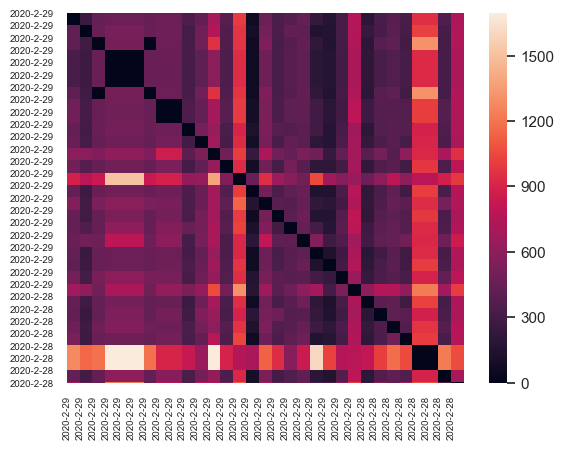

In [399]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.xticks(index, fileids, size = 7)
plt.yticks(index, fileids, size = 7)
plt.show()

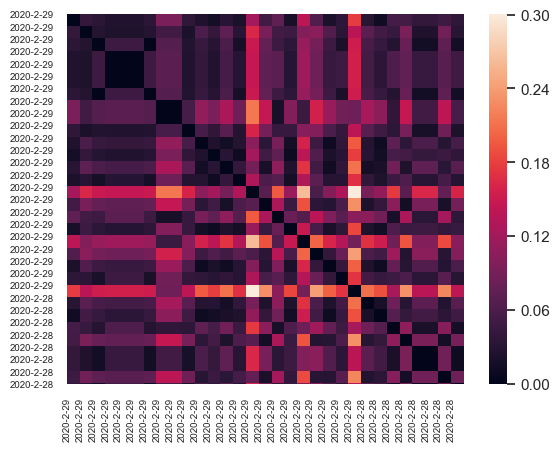

In [400]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.xticks(index, fileids, size = 7)
plt.yticks(index, fileids, size = 7)
plt.show()

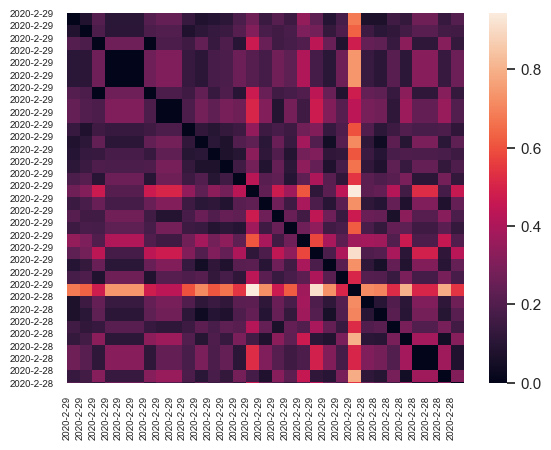

In [401]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.xticks(index, fileids, size = 7)
plt.yticks(index, fileids, size = 7)
plt.show()

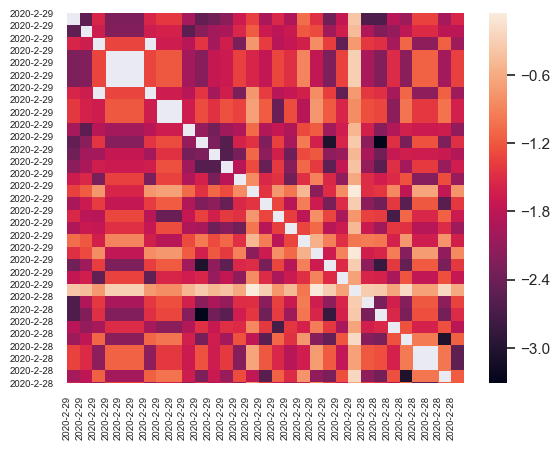

In [402]:
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.xticks(index, fileids, size = 7)
plt.yticks(index, fileids, size = 7)
plt.show()